In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras import preprocessing
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from keras import layers, models, utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.losses import BinaryCrossentropy

In [2]:
# READING DATA

image_size = (150,150)
batch_size = 128

labels = [name for name in os.listdir("./archive/seg_train/seg_train") if os.path.isdir("./archive/seg_train/seg_train/"+name)]
print(labels)

X_train = tf.keras.preprocessing.image_dataset_from_directory(
    "./archive/seg_train/seg_train",
    subset='training',
    validation_split=0.2,
    labels='inferred',
    class_names=['buildings','forest','glacier','mountain','sea','street'],
    shuffle=True,
    seed=1,
    image_size=image_size,
    batch_size=batch_size)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "./archive/seg_train/seg_train",
    subset='validation',
    validation_split=0.2,
    labels='inferred',
    class_names=['buildings','forest','glacier','mountain','sea','street'],
    shuffle=True,
    seed=1,
    image_size=image_size,
    batch_size=batch_size)

X_test = tf.keras.preprocessing.image_dataset_from_directory(
    "./archive/seg_test/seg_test",
    labels='inferred',
    class_names=['buildings','forest','glacier','mountain','sea','street'],
    seed=1,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size)

['sea', 'forest', 'buildings', 'street', 'glacier', 'mountain']
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [3]:
def ImageClassificationModel(input_shape, K):
    X_input = layers.Input(input_shape)
    X = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(X_input)
    X = Sequential()(X_input)
    X = layers.ZeroPadding2D((3, 3))(X_input)
    X = layers.Conv2D(32,kernel_size=(5,5),strides=(2,2))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((2,2))(X)
    X = layers.Dropout(0.3)(X)
    
    X = layers.Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((2,2))(X)
    X = layers.Dropout(0.3)(X)
    
    X = layers.Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((2,2))(X)
    X = layers.Dropout(0.3)(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(K,activation='softmax')(X)
    X = models.Model(inputs=X_input,outputs=X)

    return X

model = ImageClassificationModel((150,150,3),6)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 156, 156, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 76, 76, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 76, 76, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 76, 76, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 32)       0     

In [5]:
model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,epochs=40,batch_size=128,validation_batch_size=batch_size,validation_data=X_validation)
score = model.evaluate(X_train,batch_size=batch_size)
score = model.evaluate(X_test,batch_size=batch_size)

Epoch 1/40
88/88 [==============================] - 68s 770ms/step - loss: 1.5016 - accuracy: 0.5518 - val_loss: 1.3374 - val_accuracy: 0.5481
Epoch 2/40
88/88 [==============================] - 70s 794ms/step - loss: 0.8882 - accuracy: 0.6797 - val_loss: 1.2608 - val_accuracy: 0.5820
Epoch 3/40
88/88 [==============================] - 70s 797ms/step - loss: 0.7666 - accuracy: 0.7309 - val_loss: 1.0238 - val_accuracy: 0.6294
Epoch 4/40
88/88 [==============================] - 70s 797ms/step - loss: 0.6896 - accuracy: 0.7557 - val_loss: 0.8410 - val_accuracy: 0.7049
Epoch 5/40
88/88 [==============================] - 70s 792ms/step - loss: 0.6313 - accuracy: 0.7745 - val_loss: 1.8051 - val_accuracy: 0.5053
Epoch 6/40
88/88 [==============================] - 70s 790ms/step - loss: 0.6097 - accuracy: 0.7870 - val_loss: 1.3145 - val_accuracy: 0.5937
Epoch 7/40
88/88 [==============================] - 70s 793ms/step - loss: 0.5903 - accuracy: 0.7944 - val_loss: 1.2744 - val_accuracy: 0.5923

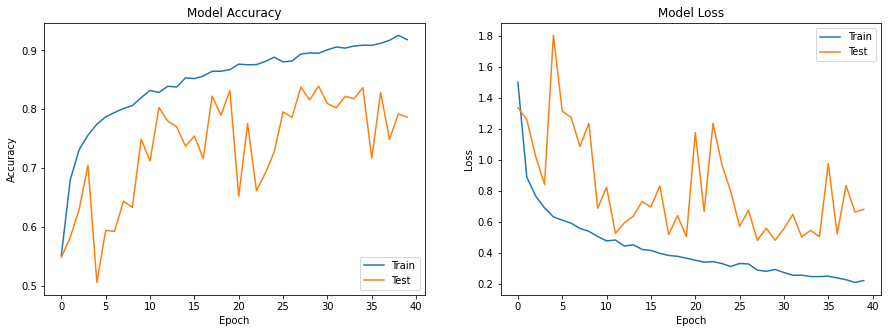

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')